## Sentiment analysis of the lyrics

We will use the same dataframe use to build the network. It has merged songs duplications.

In [12]:
import pickle
import numpy as np
import pandas as pd

import os
import json
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import string

import requests
from bs4 import BeautifulSoup
from collections import defaultdict

import matplotlib.pyplot as plt

In [13]:
#load de data from .pkl file
loaded_df = pd.read_pickle("ts_data.pkl")


We build a function that takes the LabMT wordlist as a parameter and it returns the dictionary with the words in the file and their correspondant sentiment score.

In [14]:
def sentiment_dictionary(LabMT = 'data/Data_Set_S1.txt'):
    """
    This function loads the LabMT wordlist and creates a dictionary of words and their happiness values.
    labMT: str, the path to the LabMT wordlist
    """
    #load the LabMT wordlist from Data_Set_S1.txt
    with open(LabMT, 'r') as f:
        lines = f.readlines()
    
    #remove the first foour lines 
    lines = lines[4:]

    #create a dictionary of words and their happiness values
    word_dict = defaultdict(float)
    for line in lines:
        line = line.split('\t')
        word = line[0]
        happiness = float(line[2])
        #print(word, happiness)
        word_dict[word] = happiness

    return word_dict

We build a function to clean and transfrom the lyrics into tokens.

In [15]:
def lyrics_to_tokens(lyrics):
    """
    This function takes a string of lyrics and returns a list of tokens.
    lyrics: str, a string of lyrics    
    """
    #convert to lower case
    lyrics = lyrics.lower()
    #remove stopwords
    stop_words = set(stopwords.words('english'))
    #remove punctuation
    lyrics = lyrics.translate(str.maketrans('', '', string.punctuation))
    #tokenize the lyrics
    tokens = word_tokenize(lyrics)

    tokens = [word for word in tokens if word not in stop_words]
    #lemmatize the tokens
    #lemmatizer = WordNetLemmatizer() We do not lemmatize the words because the LabMT wordlist is not lemmatized
    return tokens

Here we build a function that calculates the sentiment of a song based on the word dictionary previously obtained. To calculate the sentiment score we use the weighted sum, so that the words contribute to the sentiment score based on the frequency in which they appear. Furthermore, this function also returns the words that are present in the LabMT wordlist with the scores and their frequency in the song.

In [16]:
#function to calculate sentiment given a list of tokens based on the LabMT wordlist dictionary
def sentiment_with_words(lyrics, word_dict):
    """
    This function calculates the sentiment of a list of tokens based on the LabMT wordlist dictionary. 
    It also returns the words that are in the LabMT wordlist, their frequency and scores
    tokens: list, a list of tokens
    word_dict: dict, a dictionary of words and their happiness values
    """
    tokens = lyrics_to_tokens(lyrics)
    #calculate the frequency of each word in the tokens list
    freq = defaultdict(int)
    for token in tokens:
        freq[token] += 1

    word_list = []
    #calculate the happiness score of the tokens list
    score = 0
    count = 0
    for word in freq:
        if word in word_dict:
            word_list.append((word, freq[word], word_dict[word]))
            score += freq[word] * word_dict[word]
            count += freq[word]
            sentiment = score / count
    return sentiment, word_list


Next we build the function that iterates through the dataframe and obtains the sentiment score for each song (using the previously defined function) and also returns the three happiest and saddest words in each song

In [17]:
def calculate_sentiments_with_details(df, low_threshold, high_threshold):
    """
    This function calculates the sentiment of each track in the dataframe and returns the happiest and saddest words.
    df: pandas dataframe, a dataframe with a column of track lyrics
    """
    # add the three happiest words and three saddest words to the sentiments_dict with their scores and frequencies
    word_dict = sentiment_dictionary()
    sentiments_dict = defaultdict(dict)
    for index, row in df.iterrows():
        lyrics = row['track_lyrics']
        if type(lyrics) == list:
            for lyric in lyrics:
                sentiment_score, word_list = sentiment_with_words(lyric, word_dict)
                sentiments_dict[row['track_name']]['sentiment'] = round(sentiment_score,2)

                #obtain the percentage of sentiment category
                happy_percentage = round((len([word for word in word_list if word[2] > high_threshold]) / len(word_list))*100,2)
                sentiments_dict[row['track_name']]['happy_percentage'] = happy_percentage
                sad_percentage = round((len([word for word in word_list if word[2] < low_threshold]) / len(word_list))*100,2)
                sentiments_dict[row['track_name']]['sad_percentage'] = sad_percentage
                neutral_percentage = 100 - happy_percentage - sad_percentage
                sentiments_dict[row['track_name']]['neutral_percentage'] = neutral_percentage

                #order the word_list by score
                word_list = sorted(word_list, key=lambda x: x[2])
                sentiments_dict[row['track_name']]['saddest words'] = word_list[:3]
                sentiments_dict[row['track_name']]['happiest words'] = word_list[-3:]
        else:
            sentiment_score, word_list = sentiment_with_words(lyrics, word_dict)
            sentiments_dict[row['track_name']]['sentiment'] = round(sentiment_score,2)

            #obtain the percentage of sentiment category
            happy_percentage = round((len([word for word in word_list if word[2] > high_threshold]) / len(word_list))*100,2)
            sentiments_dict[row['track_name']]['happy_percentage'] = happy_percentage
            sad_percentage = round((len([word for word in word_list if word[2] < low_threshold]) / len(word_list))*100,2)
            sentiments_dict[row['track_name']]['sad_percentage'] = sad_percentage
            neutral_percentage = 100 - happy_percentage - sad_percentage
            sentiments_dict[row['track_name']]['neutral_percentage'] = neutral_percentage
            

            #order the word_list by score
            word_list = sorted(word_list, key=lambda x: x[2])
            sentiments_dict[row['track_name']]['saddest words'] = word_list[:3]
            sentiments_dict[row['track_name']]['happiest words'] = word_list[-3:]

    return sentiments_dict

In [18]:
#obtain the dictionary with the words and their happiness values
word_dict = sentiment_dictionary()

sentiment_values = np.array(list(word_dict.values()))

#calculate the thresholds for three categories: sad, neutral and happy
low_threshold = np.percentile(sentiment_values, 33)  
high_threshold = np.percentile(sentiment_values, 66)

print(f'The words with a sentiment score below {low_threshold} are considered sad')
print(f'The words with a sentiment score between {low_threshold} and {high_threshold} are considered neutral')
print(f'The words with a sentiment score above {high_threshold} are considered happy')

The words with a sentiment score below 5.08 are considered sad
The words with a sentiment score between 5.08 and 5.78 are considered neutral
The words with a sentiment score above 5.78 are considered happy


In [19]:
song_sentiments_with_details = calculate_sentiments_with_details(loaded_df, low_threshold, high_threshold)
song_sentiments_with_details

defaultdict(dict,
            {'"Slut!" (Taylor\'s Version) (From The Vault)': {'sentiment': 5.48,
              'happy_percentage': 40.48,
              'sad_percentage': 38.1,
              'neutral_percentage': 21.42,
              'saddest words': [('crime', 1, 2.2),
               ('ill', 1, 2.42),
               ('mistake', 1, 2.78)],
              'happiest words': [('rose', 1, 7.32),
               ('pretty', 1, 7.32),
               ('love', 7, 8.42)]},
             '...Ready For It?': {'sentiment': 5.73,
              'happy_percentage': 41.77,
              'sad_percentage': 35.44,
              'neutral_percentage': 22.79,
              'saddest words': [('failure', 1, 2.06),
               ('killer', 1, 2.42),
               ('stealing', 1, 2.46)],
              'happiest words': [('dreams', 8, 7.44),
               ('loved', 1, 7.96),
               ('love', 1, 8.42)]},
             'A Perfectly Good Heart': {'sentiment': 5.5,
              'happy_percentage': 37.5,
     

In [20]:
#calculate the stats of all the sentiments
sentiments = [value['sentiment'] for value in song_sentiments_with_details.values()]
sentiments = np.array(sentiments)

print('Mean sentiment:', np.mean(sentiments))
print('Median sentiment:', np.median(sentiments))
print('Standard deviation sentiment:', np.std(sentiments))
print('Minimum sentiment:', np.min(sentiments))
print('Maximum sentiment:', np.max(sentiments))

Mean sentiment: 5.51136170212766
Median sentiment: 5.53
Standard deviation sentiment: 0.24309497535718683
Minimum sentiment: 4.61
Maximum sentiment: 6.24


In [21]:
#calculate the stats of the happiest words. We will use the happiest words from all the songs taking into account that they may be repeated
happiest_words = []
for value in song_sentiments_with_details.values():
    happiest_words.extend([word[0] for word in value['happiest words']])
happiest_words = np.array(happiest_words)

In [22]:
rows = []

for song, data in song_sentiments_with_details.items():
    rows.append({
        "Song": song,
        "Sentiment": data["sentiment"],
        "Happy %": data["happy_percentage"],
        "Sad %": data["sad_percentage"],
        "Neutral %": data["neutral_percentage"],
        "Happiest Words": ", ".join([f"{word} ({score})" for word, _, score in data["happiest words"]]),
        "Saddest Words": ", ".join([f"{word} ({score})" for word, _, score in data["saddest words"]]),
    })

sentiment_df = pd.DataFrame(rows)

# Mostrar el DataFrame
sentiment_df.head()

,Song,Sentiment,Happy %,Sad %,Neutral %,Happiest Words,Saddest Words
0,"""Slut!"" (Taylor's Version) (From The Vault)",5.48,40.48,38.10,21.42,"rose (7.32), pretty (7.32), love (8.42)","crime (2.2), ill (2.42), mistake (2.78)"
1,...Ready For It?,5.73,41.77,35.44,22.79,"dreams (7.44), loved (7.96), love (8.42)","failure (2.06), killer (2.42), stealing (2.46)"
2,A Perfectly Good Heart,5.50,37.50,32.50,30.00,"heart (7.22), perfectly (7.28), love (8.42)","tear (3.1), scar (3.28), cant (3.48)"
3,A Place in this World,5.38,39.66,22.41,37.93,"life (7.32), lucky (7.68), sunshine (7.94)","ill (2.42), wrong (3.14), alone (3.32)"
4,Afterglow,5.01,34.21,39.47,26.32,"like (7.22), heart (7.22), love (8.42)","jail (1.76), crying (2.04), hurt (2.18)"


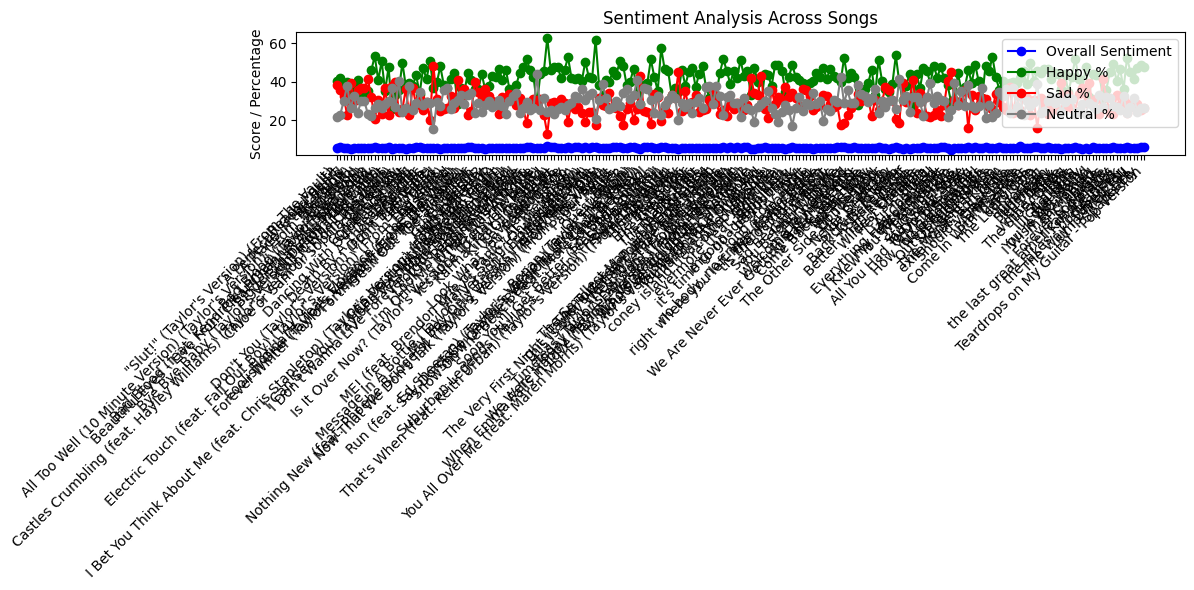

In [23]:
songs = sentiment_df["Song"]
happy = sentiment_df["Happy %"]
sad = sentiment_df["Sad %"]
neutral = sentiment_df["Neutral %"]

plt.figure(figsize=(12, 6))
plt.plot(songs, sentiment_df["Sentiment"], marker="o", label="Overall Sentiment", color="blue")
plt.plot(songs, happy, marker="o", label="Happy %", color="green")
plt.plot(songs, sad, marker="o", label="Sad %", color="red")
plt.plot(songs, neutral, marker="o", label="Neutral %", color="gray")

# Personalizar
plt.title("Sentiment Analysis Across Songs")
plt.ylabel("Score / Percentage")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()

# Mostrar
plt.show()

## Album critics analysis

To analyze the critics of the albums, we will study their reviews and the overall streams.

To study the reviews, we will obtain the information from Metacritic, a website that summarizes reviews from different categories

### Web scrapping of Metacritic

First we need to get the links to the pages that will allow us to scrape the desired information.

In [ ]:
links = [
'https://www.metacritic.com/music/taylor-swift/taylor-swift',
'https://www.metacritic.com/music/1989/taylor-swift', 
'https://www.metacritic.com/music/fearless/taylor-swift', 
'https://www.metacritic.com/music/speak-now/taylor-swift', 
'https://www.metacritic.com/music/red/taylor-swift', 
'https://www.metacritic.com/music/reputation/taylor-swift', 
'https://www.metacritic.com/music/lover/taylor-swift',
'https://www.metacritic.com/music/folklore/taylor-swift',
'https://www.metacritic.com/music/evermore/taylor-swift',
'https://www.metacritic.com/music/fearless-taylors-version/taylor-swift'
'https://www.metacritic.com/music/red-taylors-version/taylor-swift',
'https://www.metacritic.com/music/midnights/taylor-swift',
'https://www.metacritic.com/music/speak-now-taylors-version/taylor-swift',
'https://www.metacritic.com/music/1989-taylors-version/taylor-swift',
'https://www.metacritic.com/music/the-tortured-poets-department/taylor-swift',
'https://www.metacritic.com/music/the-tortured-poets-department-the-anthology/taylor-swift']

We then built a function that returns the source, score and summary of each review.

In [ ]:
def scrape_metacritic_reviews(url, n_critics):
    """
    Function that extracts the critic reviews from a Metacritic page.
    url: str, the URL of the Metacritic page of the album reviews
    n_critics: int, the number of critics to extract
    """
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Failed to fetch {url} with status code {response.status_code}")
        return None
    
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract all sources
    critic_sources = []
    source_div = soup.find_all("div", class_="source")
    for source in source_div:
        source_name = source.find("a").text.strip() if source.find("a") else "Source Not Found"
        #print(source_name)
        critic_sources.append(str(source_name))
    
    # Extract all critic scores
    critic_scores = []
    review_grade_divs = soup.find_all("div", class_="review_grade")
    for review_grade in review_grade_divs:
        score = review_grade.find("div", class_="metascore_w")
        if score:
            critic_scores.append(int(score.text.strip()))

    # Extract all review bodies
    review_bodies = []
    review_body_divs = soup.find_all("div", class_="review_body")
    for review_body in review_body_divs:
        body = review_body.text.strip() if review_body else "No Review Body"
        review_bodies.append(str(body))

    
    # only keep the information of the first n_critics (those corresponding to the critics' reviews)
    critic_scores = critic_scores[:n_critics]
    review_bodies = review_bodies[:n_critics]
    # make a new list of tuples (critic_score, review_body)
    critic_reviews = list(zip(critic_sources, critic_scores, review_bodies))

    return critic_reviews

We also defined a function that takes the album url and extracts the link to the review pages. This function returns the album and the reviews.

In [ ]:
# Function to scrape album data from Metacritic
def scrape_metacritic_album(url):
    """
    This function takes the album url and returns the album title, number of critics and reviews.
    url: str, the URL of the Metacritic page of the album
    """

    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Failed to fetch {url} with status code {response.status_code}")
        return None
    
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract album title
    title = soup.find("h1").text.strip() if soup.find("h1") else "Title Not Found"
    print(title)

    # Extract Metascore
    metascore = soup.find("span", itemprop="ratingValue").text.strip() if soup.find("span", class_="metascore_w") else "No Metascore"
    #print(metascore)
    
    n_critics = soup.find("span", itemprop="reviewCount").text.strip() if soup.find("span", itemprop="reviewCount") else "No Critic Count"
    n_critics = int(n_critics.split()[0])
    
    # Extract review link from metascore_anchor class
    review_link_tag = soup.find("a", class_="metascore_anchor")
    review_link = review_link_tag['href'] if review_link_tag and review_link_tag.has_attr('href') else None
    if review_link:
        review_link = f"https://www.metacritic.com{review_link}"
        #print(review_link)

    reviews = scrape_metacritic_reviews(review_link, n_critics)

    # Return the extracted data
    return {
        "title": title,
        "number of critics": n_critics,
        "reviews": reviews,
    }

The last function that we build related to the web scrapping is the one that allows us to save the data in .csv files.

In [ ]:
def save_album_data_to_csv(data):
    """
    This function is used to save the album data to a CSV file.
    data: dict, a dictionary containing the album data
    """
    # Clean the album title for file naming
    title = data["title"].replace(" ", "_").replace("/", "_")

    # Create a DataFrame from the reviews
    df = pd.DataFrame(data["reviews"], columns=["source","score", "review"])

    # Define output directory and file path
    output_dir = "./data/album_reviews"
    os.makedirs(output_dir, exist_ok=True)
    csv_path = os.path.join(output_dir, f"{title}.csv")

    # Save DataFrame to CSV
    df.to_csv(csv_path, index=False)
    print(f"Saved data for album '{data['title']}' to {csv_path}")

Finally, we obtain the files with the reviews and save them.

In [ ]:
for link in links:
    data = scrape_metacritic_album(link)
    save_album_data_to_csv(data)

### Correlation between streams and metacritic score

First, we will go through the original dataset. We will only keep the songs that are included in the albums that we have reviews for. 
To be able to do this, we first need to know the albums that are available in metacritic.

In [4]:
#extract the albums from the folder album_reviews
#the album names are the files names
album_metacritics = os.listdir("./data/album_reviews")
album_metacritics = [x.split(".")[0] for x in album_metacritics]

#remove _ coming from the file name
album_metacritics = [x.replace("_", " ") for x in album_metacritics]

#change the names of the albums in the metractics files so that they are the same as in the dataset
changed_albums = album_metacritics.copy()
for album in album_metacritics:
    if "THE TORTURED" in album:
        #change to lower case from the second letter for each word
        words = album.split(" ")
        new = ""
        for w in words:
            #keep the first letter and change the rest to lower case
            new += w[0] + w[1:].lower() + " "
        #remove the last space
        new = new[:-1]
        #replace the album name
        changed_albums[changed_albums.index(album)] = new

We now can clean the dataset to keep only the songs that we are interested in.

In [6]:
data = pd.read_csv('data/taylor_swift_discography_updated.csv', sep=';', index_col = 'ID')
print(f'The original dataset has {len(data)} songs')
albums = data['album'].unique()

#remove the albums that are in metacritics and not in the network
albums = [x for x in albums if x in changed_albums]

# go through data and keep only the songs which album is in the new list
data = data[data['album'].isin(albums)]
print(f'The dataset with the reviewed album has {len(data)} songs')

The original dataset has 577 songs
The dataset with the reviewed album has 264 songs


To continue with the analysis, we will aggregate the spotify streams of each album.